# Viral gene presence
This notebook calls the presence or absence of each viral gene in each cell.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_rich = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']

### Load data
Cell infection status and tag labels:

In [5]:
viral_tag_by_cell = pd.read_csv(viral_tag_by_cell_csv)
viral_tag_by_cell = viral_tag_by_cell[['cell_barcode',
                                       'infected',
                                       'infecting_viral_tag',
                                       'total_UMIs',
                                       'viral_UMIs',
                                       'frac_viral_UMIs']]
display(viral_tag_by_cell)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429
...,...,...,...,...,...,...
3367,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048
3368,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937
3369,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182
3370,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486


Cell-gene matrix:

In [6]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3372 cells and 30959 genes


#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [7]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,0,0,0,2,0,0,3,1
1,AAACCCATCATTGCTT,1,0,0,0,3,0,5,1
2,AAACGAAAGATGTTGA,0,0,0,3,1,0,10,4
3,AAACGAAGTACTTCCC,160,506,23,2,4139,420,13060,5772
4,AAACGAAGTAGACGTG,3,45,11,319,608,31,1582,2055
...,...,...,...,...,...,...,...,...,...
3367,TTTGATCTCCCGTTCA,0,0,0,0,1,0,1,1
3368,TTTGATCTCGCATTGA,30,85,15,616,1237,1344,4841,2247
3369,TTTGGAGAGTTGCCTA,0,0,0,0,1,1,6,4
3370,TTTGGAGGTATCGTTG,8,57,7,93,418,45,1668,1230


Merge in infection/infecting viral tag information:

In [8]:
viral_gene_expression = pd.merge(
    left=viral_tag_by_cell,
    right=viral_gene_expression,
    on=['cell_barcode'],
    validate='one_to_one'
)

display(viral_gene_expression)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,0,0,0,2,0,0,3,1
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,1,0,0,0,3,0,5,1
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,0,0,0,3,1,0,10,4
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,160,506,23,2,4139,420,13060,5772
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,3,45,11,319,608,31,1582,2055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,0,0,1,0,1,1
3368,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,30,85,15,616,1237,1344,4841,2247
3369,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,0,0,0,0,1,1,6,4
3370,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,57,7,93,418,45,1668,1230


Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [13]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs',
             'frac_viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_gene_UMIs
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,fluPB2,0,0.000000
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,fluPB2,1,0.000011
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,fluPB2,0,0.000000
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,fluPB2,160,0.002816
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluPB2,3,0.000024
...,...,...,...,...,...,...,...,...,...
26971,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,fluNS,1,0.000016
26972,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,fluNS,2247,0.013147
26973,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,fluNS,4,0.000061
26974,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,fluNS,1230,0.008193


Check that total number of rows is = total number of cells * total number of genes:

In [14]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes listed for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [15]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Plot distribution of absolute UMI counts for each gene:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 11443 rows containing non-finite values.


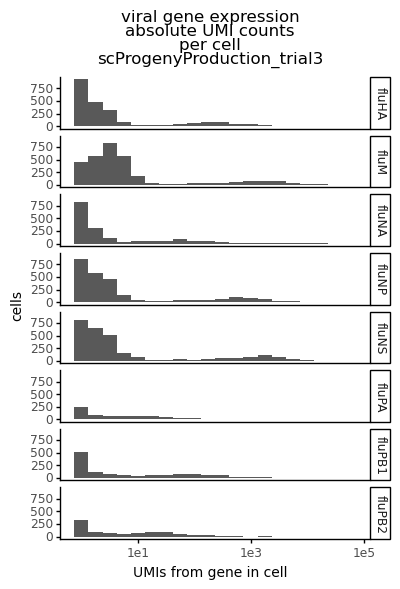

<ggplot: (8793418232098)>

In [19]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

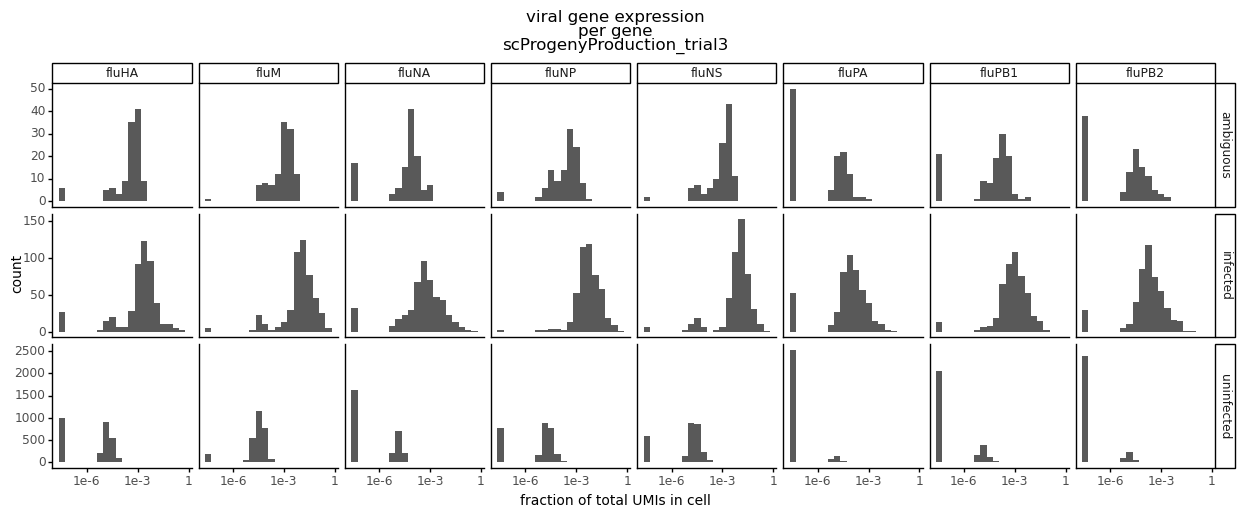

<ggplot: (8793417346064)>

In [24]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene', scales='free_y') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Call presence/absence of viral genes
Next I will extract the 90 percentile value from the uninfected cells. We were very conservative in calling cells as infected (likely there are some infected cells in the population labelled "uninfected"). A priori, we expect most infected cells to express most viral genes. So we can be more lenient in what we use as a cutoff in calling a gene present.

For low expressing genes (e.g. the polymerase complex), the 95th percentile is a value of 0, and this threshold does not work well. Instead, we will simply call genes without **any** UMIs as absent, and genes with at least 1 UMI as present.  In some previous analyses (e.g. [Russel et al. 2018](https://elifesciences.org/articles/32303)) a single transcript was used to call the presence of a gene in infected cells.

In [ ]:
limit_percentile = 0.9
limit = dict()

for gene in viral_genes:
    limit[gene] = (viral_gene_expression_long
                   .query('(infecting_viral_tag == "none") '
                          f'and (gene == "{gene}")')
                   ['frac_gene_UMIs']
                   .quantile(limit_percentile))

limit = pd.DataFrame.from_dict(limit, orient='index')
limit = limit.reset_index()
limit = limit.rename(columns={0: 'limit_frac',
                              'index': 'gene'})

limit

In [ ]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

In [ ]:
Build a poisson distribution around this value. I will perform a statistical test to see if the value seen for each gene in infected cells falls within this distribution or rejects the null hypothesis.

Now calculate the expected number of UMIs for each gene using this upper bound limit. For every cell and gene, I will simply multiply the total number of UMIs by this limit value.

In [ ]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=limit,
    on=['gene'],
    how='left'
    )

In [ ]:
Calculate the expected number of UMIs corresponding to this limit fraction for each cell.

In [ ]:
viral_gene_expression_long['limit_UMIs'] = (viral_gene_expression_long['total_UMIs'] *
                                            viral_gene_expression_long['limit_frac'])
viral_gene_expression_long

Calculate the p-value that a gene is present above the background distribution (poisson distribution with mu = `limit_UMIs`).

A few notes on how this is calculated:  
* We want the probability of yielding greater than **or equal to** the observed number of UMIs for each gene.
* `P = scipy.stats.poisson.cdf(k = x, mu = l)` returns the probability of yielding less than or equal to the observed number of UMIs (`x`) for each gene.
* To get the probability of yielding **greater than** `x`, we simply take `1 - P`.
* Because the Poisson distribution functions on integers, to get the probability of yielding a value greater than **or equal to**, we simply calcuate P on `x - 1`.

The final expression to return the **probability of yielding greater than or equal to the observed number of UMIs** is:  
`P = 1 - scipy.stats.poisson.cdf(k = (x-1), mu = l)`

In [ ]:
p_cutoff = 0.05

viral_gene_expression_long['null_P'] = (
    1 - scipy.stats.poisson.cdf(
        k=(viral_gene_expression_long['gene_UMIs']-1),
        mu=viral_gene_expression_long['limit_UMIs']))

viral_gene_expression_long['gene_present'] = (
    (viral_gene_expression_long['gene_UMIs'] > 0)
    & (viral_gene_expression_long['null_P'] < p_cutoff))

viral_gene_expression_long

Plot the proportion of viral UMIs from each gene against the p value for every cell:

In [ ]:
fig = (p9.ggplot((viral_gene_expression_long),
                 p9.aes(x='frac_gene_UMIs',
                        y='null_P',
                        color='gene_present')) +
       p9.geom_point() +
       p9.facet_grid('infected~gene') +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]) +
       p9.scale_x_log10()
       )
display(fig)

Color the proportion histogram by present/absent call:

In [ ]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs',
                        fill='gene_present')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]])
       )
display(fig)

In general, expression of all viral genes correlates with one another.  Let's check to see if we are correctly excluding viral genes that violate this correlation:

In [ ]:
fig = (p9.ggplot((viral_gene_expression_long
                  .query('infected == "infected"')),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_gene_UMIs',
                        color='gene_present')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction viral UMIs in cell',
               y='fraction of UMIs assigned to gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Annotate the fraction of cells that have each viral gene:

In [ ]:
has_gene = pd.DataFrame(
    viral_gene_expression_long
    .query('infecting_viral_tag != "both"')
    .groupby(['infected',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

has_gene

Plot this fraction for each gene and infecting viral tag:

In [ ]:
fig = (p9.ggplot((has_gene),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('gene is present above uninfected background\n'
                         f'{expt}') +
              p9.ylab('prop cells') +
              p9.facet_grid('infected~') +
              p9.theme(figure_size=(4, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)